In [100]:
import os
from pathlib import Path
from zipfile import ZipFile
import urllib.request

import torch
from torch import nn
from tfrecord.torch.dataset import MultiTFRecordDataset

import matplotlib.pyplot as plt
from matplotlib import colors

# parameters
BATCH_SIZE=256
FEATURES = [
    "elevation",
    "th",
    "vs",
    "tmmn",
    "tmmx",
    "sph",
    "pr",
    "pdsi",
    "NDVI",
    "population",
    "erc",
    "PrevFireMask",
]
LABELS = ["FireMask"]

ARR_SIZE = 4096
LENGTH, WIDTH = 64, 64

In [101]:
# set up data directory
data_dir = os.path.join(os.path.abspath("."), "data")
Path(data_dir).mkdir(parents=True, exist_ok=True)

In [102]:
# download data zip
data_zip = os.path.join(data_dir, "archive.zip")
if not os.path.exists(data_zip):
    url = "https://www.kaggle.com/api/v1/datasets/download/fantineh/next-day-wildfire-spread"
    urllib.request.urlretrieve(url, data_zip)

In [103]:
# extract files from zip
files = []
with ZipFile(data_zip, "r") as z:
    for file in z.namelist():
        files.append(Path(file).stem)
        if not os.path.exists(os.path.join(data_dir, file)):
            z.extract(file, data_dir)

In [104]:
# get all records into a data loader
tfrecord_path = os.path.join(data_dir, "{}.tfrecord")
dataset = MultiTFRecordDataset(
    tfrecord_path, 
    None, 
    splits={file: 1.0 for file in files}
)
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)

In [105]:
data = next(iter(loader))

In [106]:
# gather batch of features
features = torch.cat([data[key][:, :, None] for key in FEATURES], dim=2)
features = features.reshape(BATCH_SIZE, LENGTH, WIDTH, len(FEATURES))
features.shape

torch.Size([256, 64, 64, 12])

In [107]:
# gather batch of label(s)
labels = torch.cat([data[key][:, :, None] for key in LABELS], dim=2)
labels = labels.reshape(BATCH_SIZE, LENGTH, WIDTH, len(LABELS))
labels.shape

torch.Size([256, 64, 64, 1])

In [108]:
# visualize features and labels

rows = 5
cols = 13
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

TITLES = [
  'Elevation',
  'Wind Direction',
  'Wind Velocity',
  'Min Temperature',
  'Max Temperature',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population Density',
  'Energy Release Component',
  'Previous Fire Mask',
  'Fire Mask'
]

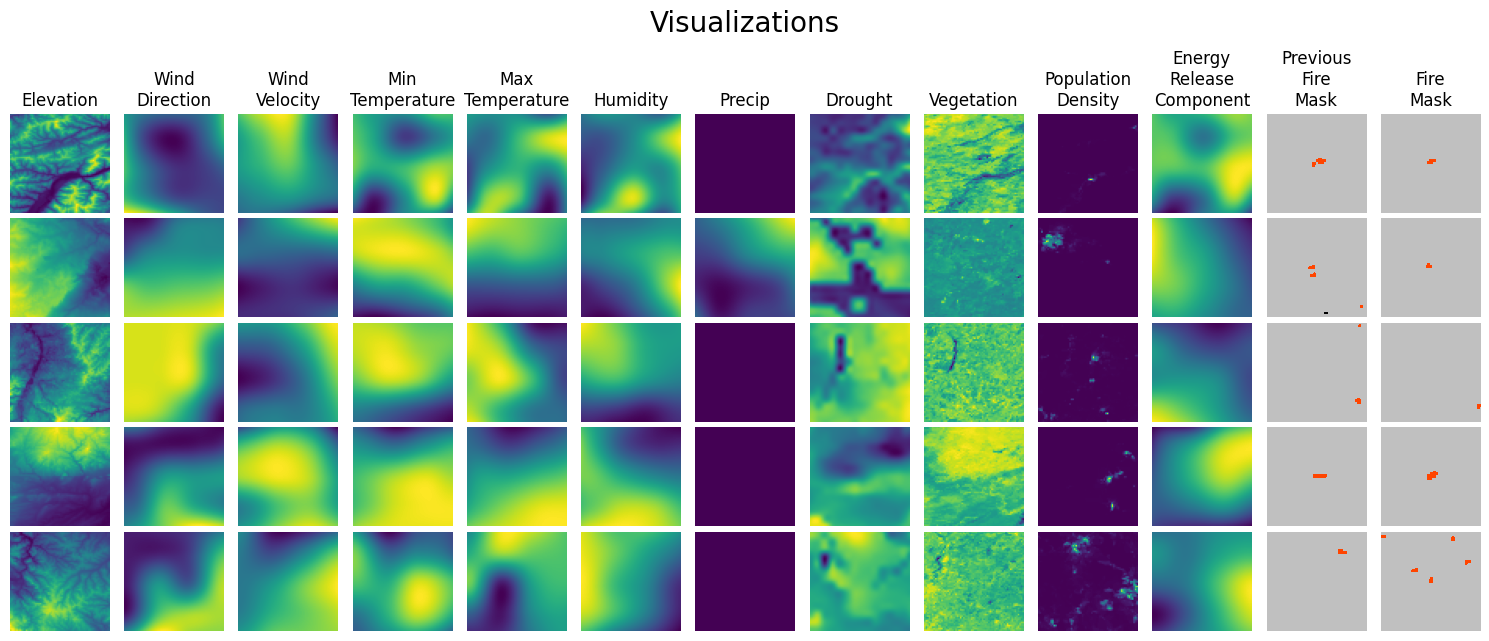

In [111]:
fig = plt.figure(figsize=(15,6.5))
fig.suptitle("Visualizations", fontsize=20)
# samples
for i in range(rows):
    # features and labels
    for j, plot in enumerate(torch.cat(
            (features[i], labels[i]), dim=2
    ).permute(2, 0, 1)):
        plt.subplot(rows, cols, i*(cols)+j+1)
        if i==0:
            title = TITLES[j].replace(' ', '\n')
            plt.title(title)
        if j >= cols-2:
            plt.imshow(plot, cmap=CMAP, norm=NORM)
        else:
            plt.imshow(plot, cmap='viridis')          
        plt.axis('off')
plt.tight_layout()